In [3]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.compute as pc
import pyarrow.dataset as ds
import math
import re
import ahocorasick
import datetime
from tqdm import tqdm

## Analysis of Canonical Peptides

In [4]:
parq_file = "/home1/wangd/project/PXD010154-1de73bcb-ee3e-4d19-9d8d-da72f11d5fac.psm.parquet"
table = pq.read_table(parq_file)
df = table.to_pandas()

In [5]:
df

,sequence,protein_accessions,protein_start_positions,protein_end_positions,protein_global_qvalue,unique,modifications,retention_time,charge,exp_mass_to_charge,...,is_decoy,id_scores,consensus_support,reference_file_name,scan_number,mz_array,intensity_array,num_peaks,gene_accessions,gene_names
0,GAGGAGSGGCCCCVLGWLGVALCGLALLSGLVLGLLVGR,[DECOY_GCA_315848],[115],[153],0.383534,1,[10|11|12|13|23-UNIMOD:4],182368.1280,4,958.501276,...,1,['OpenMS:Target-decoy PSM q-value': 0.00704929...,NaN,01524_A01_P015424_S00_N01_R1,12179,None,None,NaN,None,None
1,EYLGAICSCTCFGGQR,[GCA_131462],[2311],[2326],0.000556,1,[7|9|11-UNIMOD:4],200494.1280,2,939.900626,...,0,['OpenMS:Target-decoy PSM q-value': 0.00366430...,NaN,01524_A01_P015424_S00_N01_R1,14522,None,None,NaN,None,None
2,TCVADESAENCDK,"[GRCh38_78290, GCA_14814, CONTAMINANT_P02768-1...","[76, 76, 76, 76]","[88, 88, 88, 88]",0.000556,0,[2|11-UNIMOD:4],83191.5960,2,749.796626,...,0,['OpenMS:Target-decoy PSM q-value': 0.00383706...,NaN,01524_A01_P015424_S00_N01_R1,4604,None,None,NaN,None,None
3,AAAFEEQENETVVVK,[GRCh38_64703],[2494],[2508],0.000556,1,None,158287.7040,2,832.412626,...,0,['OpenMS:Target-decoy PSM q-value': 0.00106247...,NaN,01524_A01_P015424_S00_N01_R1,9826,None,None,NaN,None,None
4,KVADALTNAVAHVDDMPNALSALSDLHAHK,"[GRCh38_28602, GCA_72537]","[62, 62]","[91, 91]",0.000556,0,[8|18-UNIMOD:7],4640.3813,6,522.103821,...,0,['OpenMS:Target-decoy PSM q-value': 0.00055787...,NaN,01524_A01_P015424_S00_N01_R1,27647,None,None,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16294594,YFEITEEPPYIHFLNTFTSK,"[GRCh38_46198, GCA_99552]","[294, 294]","[313, 313]",0.000556,0,None,5652.1924,3,826.076477,...,0,['OpenMS:Target-decoy PSM q-value': 2.65999930...,NaN,01307_D05_P013386_S00_N36_R1,43638,None,None,NaN,None,None
16294595,SGKLDAFLVLEQLR,"[GRCh38_7521, GCA_100434, GCA_246681]","[687, 687, 687]","[700, 700, 700]",0.000556,0,None,5012.8022,3,530.308350,...,0,['OpenMS:Target-decoy PSM q-value': 0.00012527...,NaN,01307_D05_P013386_S00_N36_R1,38274,None,None,NaN,None,None
16294596,QVYEEEYGSSLEDDVVGDTSGYYQR,"[GRCh38_32181, GCA_15045]","[127, 127]","[151, 151]",0.000556,0,None,4054.3008,3,963.751770,...,0,['OpenMS:Target-decoy PSM q-value': 1.82972572...,NaN,01307_D05_P013386_S00_N36_R1,30154,None,None,NaN,None,None
16294597,LTRPGSSYFNLNPFEVLQIDPEVTDEEIK,"[GRCh38_25113, GCA_58373]","[46, 46]","[74, 74]",0.000556,0,None,6023.4970,3,1117.563232,...,0,['OpenMS:Target-decoy PSM q-value': 0.00108037...,NaN,01307_D05_P013386_S00_N36_R1,46678,None,None,NaN,None,None


In [6]:
#shorten accessions to save memory
def get_source(accessions):
    accessions = accessions.split(',')

    for acc in accessions:
        if acc.startswith('DECOY_CONTAMINANT'):
            return 'DECOY_CONTAMINANT'
    for acc in accessions:
        if acc.startswith('CONTAMINANT'):
            return 'CONTAMINANT'
    
    for acc in accessions:
        if acc.startswith('DECOY_GRCh38'):
            return 'DECOY_GRCh38'
    
    for acc in accessions:
        if acc.startswith('DECOY_GCA'):
            return 'DECOY_GCA'

    for acc in accessions:
        if acc.startswith('GRCh38'):
            return 'GRCh38'
    
    for acc in accessions:
        if acc.startswith('GCA'):
            return 'GCA'
    
    return accessions

In [7]:
print('Number of PSMs in the file = ', len(df))

Number of PSMs in the file =  16294599


In [8]:
#Convert array values in the accession to list
def join_vals(x):
    return ','.join(x.astype(str).tolist())

In [9]:
df['protein_accessions'] = df['protein_accessions'].apply(join_vals)

In [10]:
df

,sequence,protein_accessions,protein_start_positions,protein_end_positions,protein_global_qvalue,unique,modifications,retention_time,charge,exp_mass_to_charge,...,is_decoy,id_scores,consensus_support,reference_file_name,scan_number,mz_array,intensity_array,num_peaks,gene_accessions,gene_names
0,GAGGAGSGGCCCCVLGWLGVALCGLALLSGLVLGLLVGR,DECOY_GCA_315848,[115],[153],0.383534,1,[10|11|12|13|23-UNIMOD:4],182368.1280,4,958.501276,...,1,['OpenMS:Target-decoy PSM q-value': 0.00704929...,NaN,01524_A01_P015424_S00_N01_R1,12179,None,None,NaN,None,None
1,EYLGAICSCTCFGGQR,GCA_131462,[2311],[2326],0.000556,1,[7|9|11-UNIMOD:4],200494.1280,2,939.900626,...,0,['OpenMS:Target-decoy PSM q-value': 0.00366430...,NaN,01524_A01_P015424_S00_N01_R1,14522,None,None,NaN,None,None
2,TCVADESAENCDK,"GRCh38_78290,GCA_14814,CONTAMINANT_P02768-1,CO...","[76, 76, 76, 76]","[88, 88, 88, 88]",0.000556,0,[2|11-UNIMOD:4],83191.5960,2,749.796626,...,0,['OpenMS:Target-decoy PSM q-value': 0.00383706...,NaN,01524_A01_P015424_S00_N01_R1,4604,None,None,NaN,None,None
3,AAAFEEQENETVVVK,GRCh38_64703,[2494],[2508],0.000556,1,None,158287.7040,2,832.412626,...,0,['OpenMS:Target-decoy PSM q-value': 0.00106247...,NaN,01524_A01_P015424_S00_N01_R1,9826,None,None,NaN,None,None
4,KVADALTNAVAHVDDMPNALSALSDLHAHK,"GRCh38_28602,GCA_72537","[62, 62]","[91, 91]",0.000556,0,[8|18-UNIMOD:7],4640.3813,6,522.103821,...,0,['OpenMS:Target-decoy PSM q-value': 0.00055787...,NaN,01524_A01_P015424_S00_N01_R1,27647,None,None,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16294594,YFEITEEPPYIHFLNTFTSK,"GRCh38_46198,GCA_99552","[294, 294]","[313, 313]",0.000556,0,None,5652.1924,3,826.076477,...,0,['OpenMS:Target-decoy PSM q-value': 2.65999930...,NaN,01307_D05_P013386_S00_N36_R1,43638,None,None,NaN,None,None
16294595,SGKLDAFLVLEQLR,"GRCh38_7521,GCA_100434,GCA_246681","[687, 687, 687]","[700, 700, 700]",0.000556,0,None,5012.8022,3,530.308350,...,0,['OpenMS:Target-decoy PSM q-value': 0.00012527...,NaN,01307_D05_P013386_S00_N36_R1,38274,None,None,NaN,None,None
16294596,QVYEEEYGSSLEDDVVGDTSGYYQR,"GRCh38_32181,GCA_15045","[127, 127]","[151, 151]",0.000556,0,None,4054.3008,3,963.751770,...,0,['OpenMS:Target-decoy PSM q-value': 1.82972572...,NaN,01307_D05_P013386_S00_N36_R1,30154,None,None,NaN,None,None
16294597,LTRPGSSYFNLNPFEVLQIDPEVTDEEIK,"GRCh38_25113,GCA_58373","[46, 46]","[74, 74]",0.000556,0,None,6023.4970,3,1117.563232,...,0,['OpenMS:Target-decoy PSM q-value': 0.00108037...,NaN,01307_D05_P013386_S00_N36_R1,46678,None,None,NaN,None,None


In [11]:
df['prot_source'] = df['protein_accessions'].apply(get_source)

In [12]:
df['prot_source'].value_counts()

prot_source
GRCh38               10856612
GCA                   4669970
CONTAMINANT            606683
DECOY_GCA              107166
DECOY_GRCh38            53107
DECOY_CONTAMINANT        1061
Name: count, dtype: int64

#### blast GCA with canonical

In [13]:
fa_set = set()
for j in SeqIO.parse("/home1/wangd/project/can_db/Homo_sapiens.GRCh38.pep.all.fa", "fasta"):
    fa_set.add(str(j.seq))
for j in SeqIO.parse("/home1/wangd/project/can_db/uniprotkb_Homo_sapiens_AND_model_organi_2023_11_02.fasta", "fasta"):
    fa_set.add(str(j.seq))

In [14]:
def blast_with_caonical_fasta(peptide):
    for fasta in fa_set:
        if peptide in fasta:
            return "GRCh38"
    return "GCA"

In [15]:
start_time = datetime.datetime.now()
print(start_time)

seq_set = set(df["sequence"].to_list())
seq_dict = dict()
for i in tqdm(seq_set):
    seq_dict[i] = blast_with_caonical_fasta(i)

end_time = datetime.datetime.now()
print("End time :", end_time)
set_time_taken = end_time - start_time
print("Time consumption :", set_time_taken)

2023-11-06 15:44:04.031733


100%|██████████| 508840/508840 [4:05:36<00:00, 34.53it/s]  

End time : 2023-11-06 19:49:41.701224
Time consumption : 4:05:37.669491


In [16]:
df['prot_source'] = df.apply(lambda x: seq_dict.get(x['sequence']) if x['prot_source'] == 'GCA' else x['prot_source'], axis=1)

In [17]:
df['prot_source'].value_counts()

prot_source
GRCh38               15422103
CONTAMINANT            606683
DECOY_GCA              107166
GCA                    104479
DECOY_GRCh38            53107
DECOY_CONTAMINANT        1061
Name: count, dtype: int64

/tmp/ipykernel_2460053/4138984441.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gca['posterior_error_probability'],
/tmp/ipykernel_2460053/4138984441.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(grch['posterior_error_probability'],
/tmp/ipykernel_2460053/4138984441.py:15: UserWarn

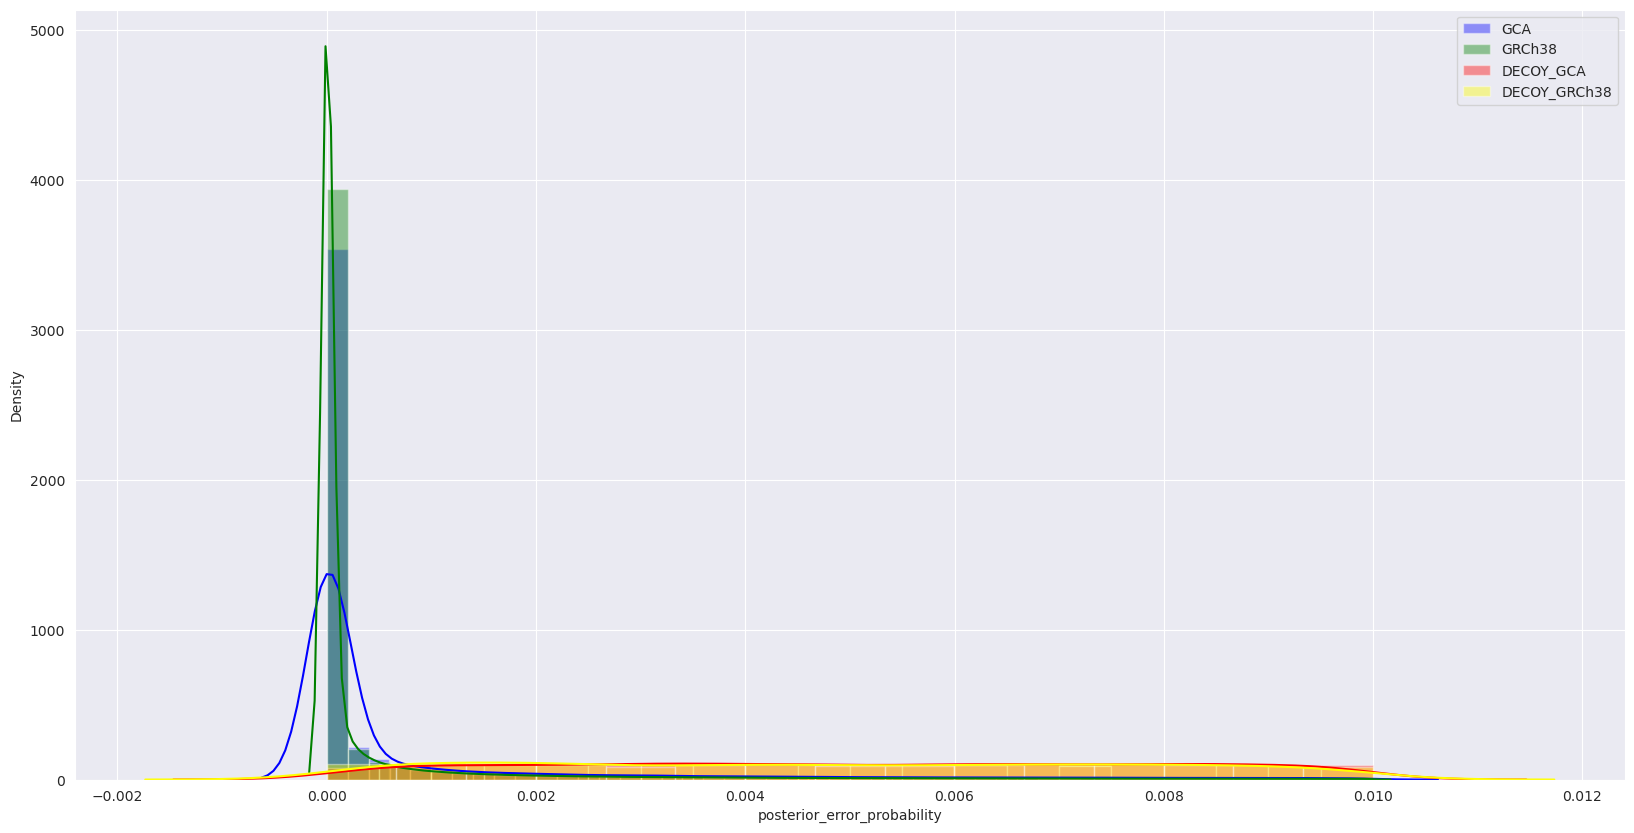

In [18]:
df2 = df[df['posterior_error_probability']<0.01]

gca = df2.loc[df2.prot_source.str.startswith("GCA")==True]
grch = df2.loc[df2.prot_source.str.startswith("GRCh38")==True]
decoy_grch = df2.loc[df2.prot_source.str.startswith("DECOY_GRCh38")==True]
decoy_gca = df2.loc[df2.prot_source.str.startswith("DECOY_GCA")==True]

#sns.df['posterior_error_probability']

plt.figure(figsize=(20, 10))
sns.distplot(gca['posterior_error_probability'], 
             hist=True, kde=True, label='GCA', color='blue')
sns.distplot(grch['posterior_error_probability'], 
             hist=True, kde=True, label='GRCh38', color='green')
sns.distplot(decoy_gca['posterior_error_probability'], 
             hist=True, kde=True, label='DECOY_GCA', color='red')
sns.distplot(decoy_grch['posterior_error_probability'], 
             hist=True, kde=True, label='DECOY_GRCh38', color='yellow')

plt.legend()

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'GRCh38'),
  Text(1, 0, 'CONTAMINANT'),
  Text(2, 0, 'GCA'),
  Text(3, 0, 'DECOY_GCA'),
  Text(4, 0, 'DECOY_GRCh38'),
  Text(5, 0, 'DECOY_CONTAMINANT')])

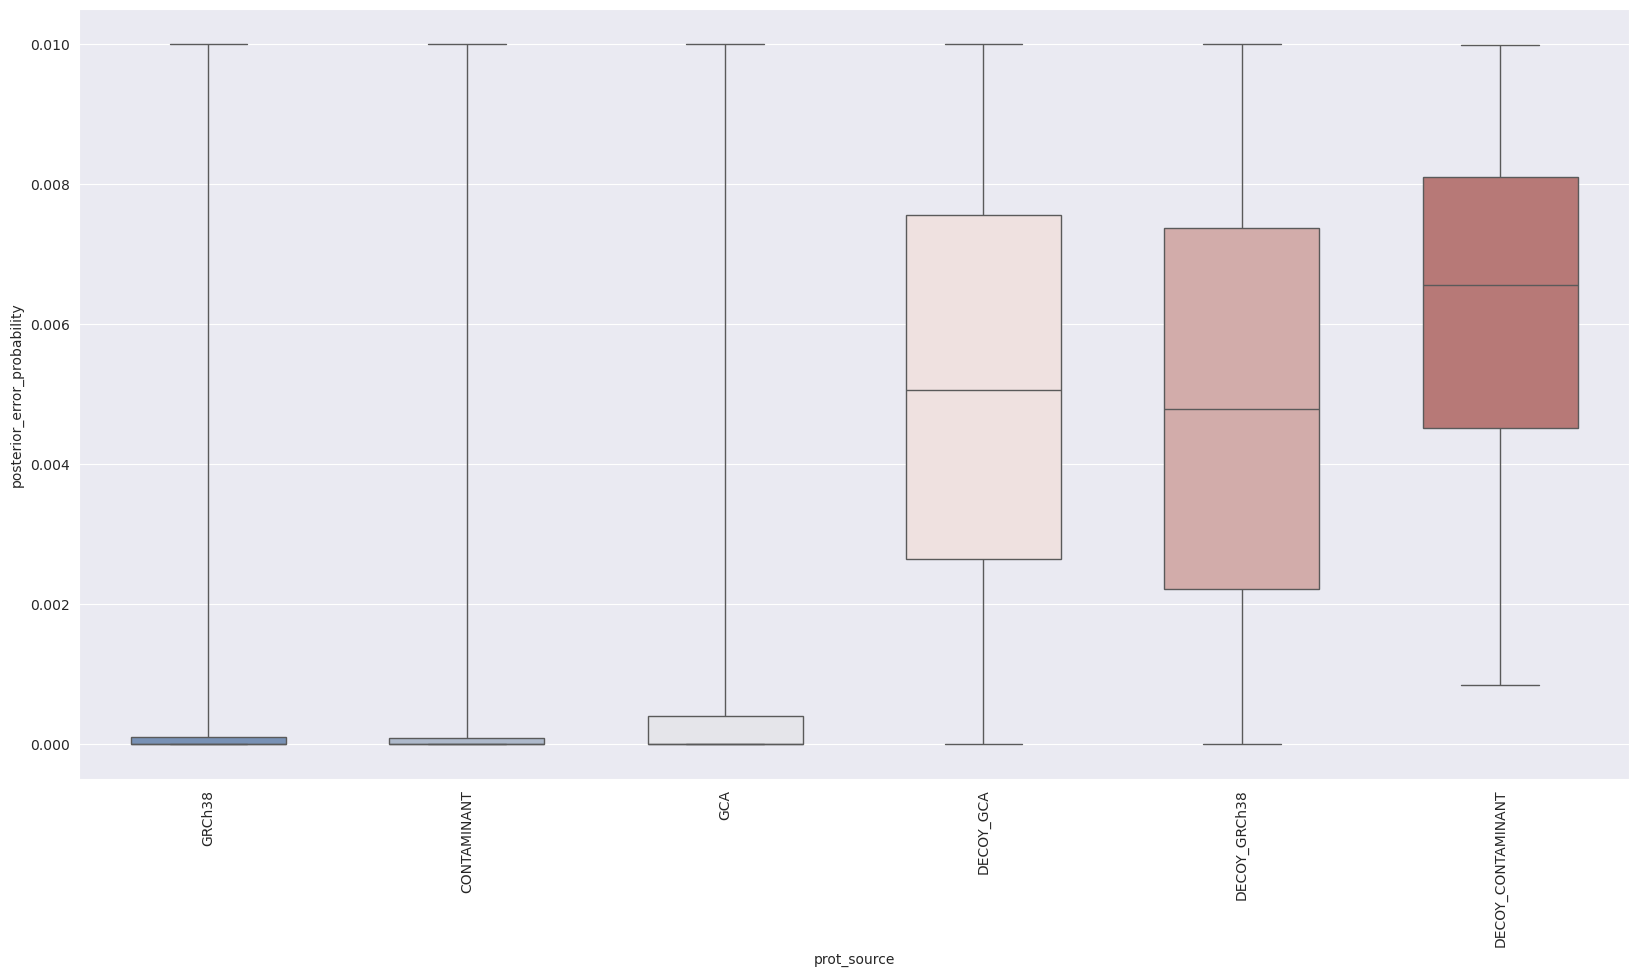

In [19]:
plt.figure(figsize=(20, 10))

sns.boxplot(
    df2, x="prot_source", y="posterior_error_probability", hue="prot_source",
    whis=[0, 100], width=.6, palette="vlag"
)
plt.xticks(rotation=90) 

In [20]:
df[df['posterior_error_probability']<0.01]['prot_source'].value_counts()

prot_source
GRCh38               13754880
CONTAMINANT            542514
GCA                     70820
DECOY_GCA                6711
DECOY_GRCh38             3148
DECOY_CONTAMINANT          46
Name: count, dtype: int64

In [21]:
print('Number of unique peptide sequences from\n GCA: {}\n canonical: {}'.format(len(gca.sequence.unique()), len(grch.sequence.unique())))
print('union', len(set(grch.sequence).union(set(gca.sequence))))
print('intesect', len(set(grch.sequence).intersection(set(gca.sequence))))

Number of unique peptide sequences from
 GCA: 5382
 canonical: 342674
union 348056
intesect 0


In [22]:
def rep(x):
    return re.sub('{[^}]*}', '', x.replace('(','{').replace(')', '}').replace('.',''))

In [23]:
gca_seqs = list(set([rep(x) for x in gca['sequence'].tolist()]))

In [24]:
len(gca_seqs)

5382

In [25]:
#get all canonical sequences from fasta
canonical_proteins_fasta = '/home1/wangd/project/can_db/Homo_sapiens.GRCh38.pep.all.fa'
allcan_seqs = []
parsed_file = SeqIO.parse(canonical_proteins_fasta,"fasta")
for record in parsed_file:
    allcan_seqs.append(str(record.seq))
allcan_seqs = list(set(allcan_seqs))
print(len(allcan_seqs))

95816


In [26]:
#get non-canonical peptides that are found in canonical proteins
gca_found_peps = []
auto = ahocorasick.Automaton()
for gca_seq in gca_seqs:
    auto.add_word(gca_seq, gca_seq)
auto.make_automaton()
for canseq in allcan_seqs:
    for end_ind, found in auto.iter(canseq):
        gca_found_peps.append(found)

In [27]:
print(len(set(gca_found_peps)))

0


In [28]:
gca_novel = gca[gca['sequence'].apply(rep).isin(gca_found_peps)==False]
print(len(gca_novel))

70820


In [29]:
print(len(set(gca_novel['sequence'].apply(rep).to_list())))

5382


#### To DeepLC

In [30]:
gca

,sequence,protein_accessions,protein_start_positions,protein_end_positions,protein_global_qvalue,unique,modifications,retention_time,charge,exp_mass_to_charge,...,id_scores,consensus_support,reference_file_name,scan_number,mz_array,intensity_array,num_peaks,gene_accessions,gene_names,prot_source
784,NHSVAESLNYVASWNMSMLQTQDLVK,GCA_64056,[284],[309],0.000556,1,"[1|15-UNIMOD:7, 16-UNIMOD:35]",5243.2000,3,995.142455,...,['OpenMS:Target-decoy PSM q-value': 2.65999930...,NaN,01524_A01_P015424_S00_N01_R1,33949,None,None,NaN,None,None,GCA
862,QSGGSSQAGAVTVSDVQELMR,"GCA_5200,GCA_5203,GCA_102666,GCA_102667","[8, 8, 8, 8]","[28, 28, 28, 28]",0.000556,0,None,4081.7000,2,1054.513854,...,['OpenMS:Target-decoy PSM q-value': 2.65999930...,NaN,01524_A01_P015424_S00_N01_R1,21737,None,None,NaN,None,None,GCA
1106,LGMIVDKIDVDKDGFVTEGELK,"GCA_118448,GCA_118449","[81, 73]","[102, 94]",0.000556,0,None,4128.1000,4,606.070749,...,['OpenMS:Target-decoy PSM q-value': 2.69298479...,NaN,01524_A01_P015424_S00_N01_R1,22238,None,None,NaN,None,None,GCA
1293,MVAVQNYHGNPAPPGKPVLTFQTGDVLELLR,GCA_180777,[581],[611],0.000556,1,[6-UNIMOD:7],5076.4000,4,841.702148,...,['OpenMS:Target-decoy PSM q-value': 5.68388783...,NaN,01524_A01_P015424_S00_N01_R1,32236,None,None,NaN,None,None,GCA
1608,VVSVLTILHQDWLNGK,GCA_268986,[182],[197],0.000556,1,[10|14-UNIMOD:7],4782.1000,3,608.674349,...,['OpenMS:Target-decoy PSM q-value': 0.00011536...,NaN,01524_A01_P015424_S00_N01_R1,29128,None,None,NaN,None,None,GCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16292783,LLPNLNDIVAVGPEHFYGTNDHYFLDPYLR,GCA_304161,[163],[192],0.000556,1,[6-UNIMOD:7],5305.5790,4,876.693420,...,['OpenMS:Target-decoy PSM q-value': 0.00062140...,NaN,01293_D05_P013196_S00_N36_R1,36388,None,None,NaN,None,None,GCA
16293735,TPEVTCVVVDVSHQDPEVQFK,GCA_263327,[186],[206],0.000556,1,"[6-UNIMOD:4, 14-UNIMOD:7]",4145.0625,3,805.726135,...,['OpenMS:Target-decoy PSM q-value': 2.65999930...,NaN,01307_D05_P013386_S00_N36_R1,30903,None,None,NaN,None,None,GCA
16294014,LLNLLADLVER,GCA_168207,[104],[114],0.000556,1,None,5940.1720,2,634.883789,...,['OpenMS:Target-decoy PSM q-value': 4.30711710...,NaN,01307_D05_P013386_S00_N36_R1,46006,None,None,NaN,None,None,GCA
16294322,DVASLSSQIQDTQELLQEETR,GCA_293797,[1316],[1336],0.000556,1,None,5055.1770,2,1195.597900,...,['OpenMS:Target-decoy PSM q-value': 0.00016379...,NaN,01307_D05_P013386_S00_N36_R1,38639,None,None,NaN,None,None,GCA


In [31]:
grch

,sequence,protein_accessions,protein_start_positions,protein_end_positions,protein_global_qvalue,unique,modifications,retention_time,charge,exp_mass_to_charge,...,id_scores,consensus_support,reference_file_name,scan_number,mz_array,intensity_array,num_peaks,gene_accessions,gene_names,prot_source
4,KVADALTNAVAHVDDMPNALSALSDLHAHK,"GRCh38_28602,GCA_72537","[62, 62]","[91, 91]",0.000556,0,[8|18-UNIMOD:7],4640.3813,6,522.103821,...,['OpenMS:Target-decoy PSM q-value': 0.00055787...,NaN,01524_A01_P015424_S00_N01_R1,27647,None,None,NaN,None,None,GRCh38
5,KVADALTNAVAHVDDMPNALSALSDLHAHK,"GRCh38_28602,GCA_72537","[62, 62]","[91, 91]",0.000556,0,"[16-UNIMOD:35, 18-UNIMOD:7]",4303.0024,6,524.601990,...,['OpenMS:Target-decoy PSM q-value': 0.00037007...,NaN,01524_A01_P015424_S00_N01_R1,24056,None,None,NaN,None,None,GRCh38
6,SLLSLPLVGSLPFLPR,"GRCh38_51683,GCA_29982","[30, 30]","[45, 45]",0.000556,0,None,6315.2000,2,855.024475,...,['OpenMS:Target-decoy PSM q-value': 0.00037979...,NaN,01524_A01_P015424_S00_N01_R1,43295,None,None,NaN,None,None,GRCh38
7,VGETAPPNAYTVTDLVEYSIVIQQLSNGK,"GRCh38_57249,GRCh38_57250,GCA_58596,GCA_58597,...","[316, 299, 316, 299, 316]","[344, 327, 344, 327, 344]",0.000556,0,None,6285.5000,3,1036.204528,...,['OpenMS:Target-decoy PSM q-value': 7.00719686...,NaN,01524_A01_P015424_S00_N01_R1,43055,None,None,NaN,None,None,GRCh38
8,STAAMSTYTGIFTDQVLSVLK,GRCh38_60780,[155],[175],0.000556,1,None,6281.9000,2,1117.574523,...,['OpenMS:Target-decoy PSM q-value': 0.00018626...,NaN,01524_A01_P015424_S00_N01_R1,43025,None,None,NaN,None,None,GRCh38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16294591,DSDWPFCSDEDWNYK,GCA_252999,[49],[63],0.000556,1,[7-UNIMOD:4],4547.4233,2,982.378723,...,['OpenMS:Target-decoy PSM q-value': 3.80555515...,NaN,01307_D05_P013386_S00_N36_R1,34237,None,None,NaN,None,None,GRCh38
16294593,AFVHWYVGEGMEEGEFSEAR,"GRCh38_43584,GCA_1722","[403, 403]","[422, 422]",0.000556,0,None,6564.6610,3,777.681580,...,['OpenMS:Target-decoy PSM q-value': 4.12148276...,NaN,01307_D05_P013386_S00_N36_R1,50165,None,None,NaN,None,None,GRCh38
16294594,YFEITEEPPYIHFLNTFTSK,"GRCh38_46198,GCA_99552","[294, 294]","[313, 313]",0.000556,0,None,5652.1924,3,826.076477,...,['OpenMS:Target-decoy PSM q-value': 2.65999930...,NaN,01307_D05_P013386_S00_N36_R1,43638,None,None,NaN,None,None,GRCh38
16294595,SGKLDAFLVLEQLR,"GRCh38_7521,GCA_100434,GCA_246681","[687, 687, 687]","[700, 700, 700]",0.000556,0,None,5012.8022,3,530.308350,...,['OpenMS:Target-decoy PSM q-value': 0.00012527...,NaN,01307_D05_P013386_S00_N36_R1,38274,None,None,NaN,None,None,GRCh38


In [32]:
mod_rep = {"UNIMOD:4":"Carbamidomethyl","UNIMOD:7":"Deamidated","UNIMOD:35":"Oxidation","UNIMOD:1":"Acetyl"}
def replace_mod(x):
    s = ""
    for mod in x:
        nums = mod.split("-")[0]
        m = mod.split("-")[1]
        for n in nums.split("|"):
            if s:
                s += "|"
            s += n + "|" + mod_rep.get(m)
    return s

In [33]:
gca.loc[:,"seq"] = gca.apply(lambda x : x["sequence"],axis = 1)
gca.loc[:,"modifications"] = gca.apply(lambda x : replace_mod(x["modifications"]) if x["modifications"] is not None else "", axis = 1)
gca.loc[:,"tr"] = gca.apply(lambda x : x["retention_time"],axis = 1)

/tmp/ipykernel_2460053/1059345756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gca.loc[:,"seq"] = gca.apply(lambda x : x["sequence"],axis = 1)
/tmp/ipykernel_2460053/1059345756.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gca.loc[:,"tr"] = gca.apply(lambda x : x["retention_time"],axis = 1)


In [34]:
grch.loc[:,"seq"] = grch.apply(lambda x : x["sequence"],axis = 1)
grch.loc[:,"modifications"] = grch.apply(lambda x : replace_mod(x["modifications"]) if x["modifications"] is not None else "", axis = 1)
grch.loc[:,"tr"] = grch.apply(lambda x : x["retention_time"],axis = 1)

/tmp/ipykernel_2460053/2314920632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grch.loc[:,"seq"] = grch.apply(lambda x : x["sequence"],axis = 1)
/tmp/ipykernel_2460053/2314920632.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grch.loc[:,"tr"] = grch.apply(lambda x : x["retention_time"],axis = 1)


In [35]:
gca.drop_duplicates(subset=["seq","modifications"],keep="first",inplace=True)
grch.drop_duplicates(subset=["seq","modifications"],keep="first",inplace=True)
gca['modifications'] = gca['modifications'].fillna("")
grch['modifications'] = grch['modifications'].fillna("")

/tmp/ipykernel_2460053/1255792564.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gca.drop_duplicates(subset=["seq","modifications"],keep="first",inplace=True)
/tmp/ipykernel_2460053/1255792564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grch.drop_duplicates(subset=["seq","modifications"],keep="first",inplace=True)
/tmp/ipykernel_2460053/1255792564.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [36]:
# import deeplc packages
from deeplc import DeepLC
from deeplcretrainer import deeplcretrainer

# Default
from collections import Counter
import os
import urllib.request

# specific packages
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import numpy as np

import tensorflow as tf
from tensorflow.python.eager import context

import warnings
warnings.filterwarnings('ignore')

In [37]:
# obtain three models for deeplc
urllib.request.urlretrieve(
    "https://github.com/compomics/DeepLC/raw/master/deeplc/mods/full_hc_hela_hf_psms_aligned_1fd8363d9af9dcad3be7553c39396960.hdf5",
    "full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5"
)

urllib.request.urlretrieve(
    "https://github.com/compomics/DeepLC/raw/master/deeplc/mods/full_hc_hela_hf_psms_aligned_8c22d89667368f2f02ad996469ba157e.hdf5",
    "full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5"
)

urllib.request.urlretrieve(
    "https://github.com/compomics/DeepLC/raw/master/deeplc/mods/full_hc_hela_hf_psms_aligned_cb975cfdd4105f97efa0b3afffe075cc.hdf5",
    "full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5"
)

URLError: <urlopen error [Errno 110] Connection timed out>

#### Transfer learning

In [ ]:
%%capture

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# For training new models we need to use a file, so write the train df to a file
grch.to_csv("grch.csv",index=False)
df_train_file = "grch.csv"

# Here we will apply transfer learning we specify previously trained models in the 'mods_transfer_learning'
models = deeplcretrainer.retrain(
    [df_train_file],
    mods_transfer_learning=["full_hc_hela_hf_psms_aligned_1fd8363d9af9dcad3be7553c39396960.hdf5",
                            "full_hc_hela_hf_psms_aligned_8c22d89667368f2f02ad996469ba157e.hdf5","full_hc_hela_hf_psms_aligned_cb975cfdd4105f97efa0b3afffe075cc.hdf5"],
    freeze_layers=True,
    n_epochs=10,
    freeze_after_concat=1
);

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make a DeepLC object with the models trained previously
dlc = DeepLC(
        path_model=models,
        batch_num=1024000,
        pygam_calibration=False
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=grch)
preds_transflearn = dlc.make_preds(seq_df=gca)

mae_transflearn = sum(abs(gca["tr"]-preds_transflearn))/len(gca["tr"].index)
perc95_transflearn = np.percentile(abs(gca["tr"]-preds_transflearn),95)*2
cor_transflearn = pearsonr(gca["tr"],preds_transflearn)[0]

In [ ]:
gca['pred_rt'] = preds_transflearn

In [ ]:
gca.to_csv('gca.tsv',sep='\t', index=False)
grch.to_csv('grch.tsv',sep='\t', index=False)